# Goal

* Create a general REACT agent that can use entrez tools to explore an Entrez record

# Init

In [1]:
# import 
import os
import re
import time
from enum import Enum
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [2]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [3]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [4]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

# Tools

In [ ]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    Example query for single cell RNA-seq:
        `("single cell"[Title] OR "single-cell"[Title] OR "scRNA-seq"[Title])`
    Example query for an ENA accession number (database = sra):
        `ERX13336121`
    Example query for a GEO accession number (database = gds):
        `GSE51372`
    """
    # debug model
    if os.getenv("DEBUG_MODE") == "TRUE":
        max_records = 2 

    # query
    records = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            # delete unneeded keys
            to_rm = ["RetMax", "RetStart"]
            for key in to_rm:
                if key in search_results.keys():
                    del search_results[key]
            # add to records
            records.append(str(search_results))
            # update retstart
            retstart += retmax
            time.sleep(0.33)
            if max_records and len(records) >= max_records:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
        
    # return records
    if len(records) == 0:
        return(f"No records found for query: {esearch_query}")
    if os.getenv("DEBUG_MODE") == "TRUE":
        records = records[:max_records]  # debug
    return records

# esearch.invoke({"esearch_query" : "GSE51372", "database" : "sra"})
# esearch.invoke({"esearch_query" : "GSE121737", "database" : "gds"})

In [33]:
@tool 
def efetch(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
    )-> Annotated[List[str], "eFetch results in xml format"]:
    """
    Run an Entrez efetch query on Entrez IDs to obtain metadata for the records.
    Useful for obtaining metadata for a specific record.
    """
    time.sleep(0.33)
    id_str = ", ".join(entrez_ids)
    # Fetch dataset record
    try:
        handle = Entrez.efetch(db=database, id=entrez_ids, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to fetch record for {id_str}")
    finally:
        handle.close()
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass

    # check for errors
    if "Error occurred: cannot get document summary" in record:
        return f"Failed to fetch record for {id_str}. Try a different database (e.g., gds, sra, or pubmed)."

    return str(record)

#records = efetch.invoke({ "entrez_ids" : ["35966237"], "database" : "sra"})
#pprint(records)
#records = efetch.invoke({"entrez_ids" : ["200254051"], "database" : "gds"})
#pprint(records)

In [ ]:
@tool
def esummary(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
) -> Annotated[List[str], "eSummary results in xml format"]:
    """
    Run an Entrez esummary query on Entrez IDs to obtain summary information for the records.
    Useful for obtaining summary information for a specific record.
    """
    time.sleep(0.33)  # Respect NCBI's rate limits
    id_str = ", ".join(entrez_ids)
    
    # Fetch summary record
    try:
        handle = Entrez.esummary(db=database, id=entrez_ids, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        return f"Failed to fetch summary for {id_str}. Check if the IDs exist."
    finally:
        handle.close()
        
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass
        
    # check for errors in the response
    if "ERROR" in record.upper() or "INVALID_ID" in record.upper():
        return f"Failed to fetch summary for {id_str}. Try a different database (gds or sra) or verify the ID."
        
    return str(record)

# esummary.invoke({"entrez_ids" : ["35966237"], "database" : "sra"})

'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE eSummaryResult PUBLIC "-//NLM//DTD esummary v1 20041029//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20041029/esummary-v1.dtd">\n<eSummaryResult>\n<DocSum>\n\t<Id>35966237</Id>\n\t<Item Name="ExpXml" Type="String">&lt;Summary&gt;&lt;Title&gt;RNA-Seq of Homo sapiens: adult female pancreas&lt;/Title&gt;&lt;Platform instrument_model="Illumina NovaSeq 6000"&gt;ILLUMINA&lt;/Platform&gt;&lt;Statistics total_runs="1" total_spots="227438532" total_bases="68231559600" total_size="26895277702" load_done="true" cluster_name="public"/&gt;&lt;/Summary&gt;&lt;Submitter acc="SRA2008902" center_name="Peking Union Medical College Hospital" contact_name="Haoran Huang" lab_name="general surgical"/&gt;&lt;Experiment acc="SRX26623215" ver="1" status="public" name="RNA-Seq of Homo sapiens: adult female pancreas"/&gt;&lt;Study acc="SRP543450" name="scRNA seq on paired samples from three advanced pancreatic cancer patients with liver metastasis"/&gt;&lt;

In [40]:
@tool
def which_entrez_databases(
    entrez_id: Annotated[str, "Entrez ID"],
) -> Annotated[Union[str, List[str]], "List of databases where the ID was found or error message"]:
    """
    Check which databases an Entrez ID is found in.
    """
    # More complete list of databases
    databases = [
        "sra", "gds", "pubmed", "biosample", "bioproject", 
    ]
    
    found_in = []
    for db in databases:
        try:
            time.sleep(0.33)
            handle = Entrez.esummary(db=db, id=entrez_id)
            record = Entrez.read(handle)
            found_in.append(db)
            handle.close()
        except Exception as e:
            continue
            
    if not found_in:
        return f"Entrez ID {entrez_id} not found in any database."
    return found_in        

# Example usage
#which_entrez_databases.invoke({"entrez_id" : "35966237"})

In [41]:
@tool
def elink(
    source_db: Annotated[str, "Source database (e.g., sra or gds)"],
    target_db: Annotated[str, "Target database (e.g., bioproject, biosample or pubmed)"],
    entrez_id: Annotated[str, "Entrez ID "],
) -> Annotated[str, "eLink results in xml format"]:
    """
    Find related entries between Entrez databases.
    This tool is particularly useful for finding BioProject, BioSample, or publication records related to SRA entries.
    """
    if source_db == target_db:
        return f"Source and target databases cannot be the same. Which database are you trying to link {source_db} to?"

    time.sleep(0.33)
    
    try:
        handle = Entrez.elink(
            dbfrom=source_db,
            db=target_db,
            id=[entrez_id],
            retmode="xml"
        )
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to find links for: {entrez_id}")
        return f"Failed to find links. Check database names and Entrez ID."
    finally:
        handle.close()
        
    try:
        record = record.decode("utf-8")
    except:
        pass
        
    if "ERROR" in record.upper():
        return f"Failed to find links. Verify database names ({source_db}, {target_db}) and Entrez ID."
        
    return str(record)

#elink.invoke({"source_db" : "sra", "target_db" : "gds", "entrez_id" : "35966237"})

# Graph

In [42]:
import operator
from typing import Annotated, Sequence, Tuple, Union, Required
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph, MessagesState
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [43]:
# set model
#model_big = ChatOpenAI(model="gpt-4o")
model = ChatOpenAI(model="gpt-4o-mini")

In [45]:
entrez_agent = create_react_agent(
    model=model,
    tools=[esearch, efetch, esummary, elink, which_entrez_databases],
    state_modifier="\n".join([
        "You are a helpful bioinformatician assisting a researcher with a task involving Entrez databases.",
        "Use the Entrez suite of tools to search for and retrieve information in order to help the researcher.",
        "Generally, start with the eSearch tool to find Entrez records, then use eFetch to get detailed information.",
        "Use eSummary to obtain summary information on an Entrez record.",
        "Use eLink to navigate between databases to find related records (e.g., GEO to SRA).",
        "Continue using your tools until you successfully complete the task.",
        "Be very concise; provide simple lists when possible; do not include unnecessary wording such as \"If you need further assistance\".",
        "\n#-- Accession notes --#",
        "SRA accesssion prefixes: SRX, SRP, SRR",
        "ENA accession prefixes: ERX, PRJNA, DRX, E-MTAB",
        "GEO accession prefixes: GSE, GSM, GPL",
        "BioProject accession prefixes: PRJNA, PRJEB, PRJDB",
        "BioSample accession prefixes: SAMN, SAME",
        "#-- Database notes --#",
        "Entrez databases: sra, gds, pubmed, biosample, bioproject",
        "#-- Example workflows --#",
        "# Task: Convert GSE123456 to SRX accessions",
        "  1. esearch of GSE accession to obtain Entrez IDs",
        "  2. esummary of the Entrez IDs to get the SRX accessions"
        "\n"
    ])
)

# invoke the agent
inputs = {"messages": [("user", "Convert GSE121737 to SRX accessions")]}
config = {"max_concurrency" : 3, "recursion_limit": 30}
#for step in entrez_agent.stream(inputs, stream_mode="values", config=config):
#    print(step)

In [46]:
# subclass the state
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    SRX: Annotated[List[str], "SRX accessions associated with the dataset."]
    SRP: Annotated[List[str], "SRP accessions associated with the dataset."]
    SRR: Annotated[List[str], "SRR accessions associated with the dataset."]

In [47]:
# node to generate a structured output of accessions
class Accesions(TypedDict):
    SRX: List[str]
    SRP: List[str]
    SRR: List[str]

def get_accessions(state: GraphState) -> Accesions:
    """
    Extract the SRA experiment accessions (SRX) from the state.
    """
     # Create a prompt template that includes previous messages
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You are an expert in bioinformatics and have been asked to analyze an SRA dataset."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "\n".join([
            "Based on the information above, determine the following:",
            "1. The SRX accessions associated with the dataset.",
            "2. The SRP accessions associated with the dataset.",
            "3. The SRR accessions associated with the dataset."
            "If you cannot find any particular type of accession, you can leave it blank."
            ])
        ),
    ])
    # Format the prompt with the message history
    formatted_prompt = prompt.format_messages(
        history=state["messages"]
    )
    # Use the formatted prompt with the LLM
    return model.with_structured_output(Accesions, strict=True).invoke(formatted_prompt)

# test get_accessions
# state = {
#     "messages": [HumanMessage(content="The accession is SRR13112659. The dataset is from a single-cell RNA-seq experiment with Illumina paired-end reads. There is another accession: SRP319646. The dataset is from a study on the human brain. The dataset is part of a larger project with the accession PR")],
# }
#get_accessions(state)

In [48]:
#-- graph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("entrez_agent_node", entrez_agent)
workflow.add_node("get_accessions_node", get_accessions)

# edges
workflow.add_edge(START, "entrez_agent_node")
#workflow.add_edge("entrez_agent_node", END)
workflow.add_edge("entrez_agent_node", "get_accessions_node")
workflow.add_edge("get_accessions_node", END)

# compile the graph
graph = workflow.compile()

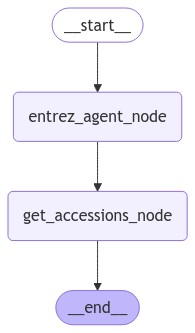

In [49]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [50]:
# Call the graph and stream
#input = {"entrez_id" : "35966237", "database" : "sra"}
#input = {"messages" : [HumanMessage(content="Entrez ID: 35966237")]}
input = {"messages" : [HumanMessage(content="Convert GSE121737 to SRX accessions")]}
for step in graph.stream(input, config={"max_concurrency" : 3, "recursion_limit": 30}):
    print(step)
    final_step = step

Error searching gds with query: GSE121737: 'Count'
{'entrez_agent_node': {'messages': [HumanMessage(content='Convert GSE121737 to SRX accessions', additional_kwargs={}, response_metadata={}, id='8b260377-d4aa-4bdf-8f4d-76a7a9168e5e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2EFmQA5XYPVg4f4OxMz2ZDW0', 'function': {'arguments': '{"esearch_query":"GSE121737","database":"gds"}', 'name': 'esearch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 725, 'total_tokens': 749, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-68c19717-ce2a-47b0-8837-5cdbe41d5450-0', tool_calls=[{'name': 'esearch', 'args': {'esea

In [51]:
final_step

{'get_accessions_node': {'SRX': ['SRX4967529', 'SRX4967528', 'SRX4967527'],
  'SRP': ['SRP167700'],
  'SRR': []}}